# INTERVIEW - BRUNO SERRA

## 1. Problem Definition

### 1.1 Objective

FabFitFun is a subscription box service that delivers a curated selection of beauty, wellness, and lifestyle products to its members. Each box typically includes a mix of full-sized items, ranging from skincare and makeup to home goods and fitness accessories. FabFitFun offers seasonal boxes four times a year and aims to provide high-quality products tailored to its subscribers' preferences. 

### 1.2 Key Questions and Insights

* Who are our most valuable members? How are they different from our less valuable members?
* Which channels are best at driving these members to sales?
* Where are purchase conversion rates strong?
* Based on your analysis, provide actionable recommendations to improve the conversion rate from visits to purchases. Explain the rationale behind each recommendation.

### 1.3 Dataset Attributes

Acquisitions
| Column                      | Definition                                                  |
|----------------------------|-------------------------------------------------------------|
| userID                     | Unique identifier for the user.                            |
| ACQUISITION_DATE           | Date the user made the acquisition.                        |
| ORDER_SEASON               | Season when the acquisition occurred.                      |
| PLAN_CODE                  | Code identifying the plan purchased by the user.           |
| SAME_DAY_REFUND            | Indicates if a same-day refund was issued.                 |
| CURRENT_SUBSCRIPTIONS_STATE | Current state of the user's subscription.                 |
| AGE                        | Age of the user at the time of acquisition.                |
| USER_REGION                | User's region of origin.                                   |
| LTV14 (in cents)           | User's 14-day Lifetime Value (LTV) in cents.               |


Visits
| Column                  | Definition                                                                 |
|------------------------|----------------------------------------------------------------------------|
| userID                 | Unique identifier for the user.                                            |
| SEASON                 | Season when the acquisition occurred.                                     |
| CAMPAIGN_ID            | Unique identifier for the marketing campaign.                             |
| WINDOW_NUMBER          | Campaign window within the season (Window 1 for Annual, 2 for Quarterly). |
| CAMPAIGN_TITLE         | Name of the campaign.                                                      |
| CAMPAIGN_TYPE          | Type of campaign.                                                          |
| WINDOW_START_TS_PST    | Start timestamp of the campaign window in PST.                            |
| WINDOW_END_TS_PST      | End timestamp of the campaign window in PST.                              |
| CHANNEL                | Channel through which the campaign was delivered.                         |
| NEW_OR_RETURNING_MEMBER | Indicates whether the user is a new or returning member.                 |
| VISIT_CNT              | Number of visits made by the user during the campaign window.             |


Purchases
| Column         | Definition                                            |
|----------------|-------------------------------------------------------|
| userID         | Unique identifier for the user.                       |
| CAMPAIGN_ID    | Unique identifier for the marketing campaign.         |
| CAMPAIGN_TITLE | Name of the campaign.                                 |
| SKU            | Unique identifier for the purchased product.          |
| CART_QUANTITY  | Quantity of the SKU added to the cart.                |
| MSRP           | Manufacturer's Suggested Retail Price of the product.|
| COGS           | Cost of Goods Sold for the product.                   |
| SALE_PRICE     | Actual price at which the product was sold.           |
| CATEGORY       | Product category or classification.                   |

Campaign (DIM)
| Column         | Definition                                          |
|----------------|-----------------------------------------------------|
| SEASON         | Season when the acquisition occurred.              |
| CAMPAIGN_ID    | Unique identifier for the marketing campaign.      |
| CAMPAIGN_TITLE | Name of the campaign.                              |
| CAMPAIGN_TYPE  | Type of campaign.                                  |


### 1.4 Imports

In [ ]:
import pandas as pd
import numpy as np
import os
import requests
import chardet
import matplotlib.pyplot as plt
import re
from datetime import datetime
from pandas import Timestamp
import warnings
warnings.filterwarnings("ignore")

## 2 Data Collection

### 3.1 Import Files

In [2]:
# Importing xls file
home_exercise = r'D:\Bruno Serra PC\Documents\Bruno\GitHub\sales-membership-analysis\DA Take Home Exercise - Bruno.xlsx'

# Creating dataframes
fact_acquisitions_df = pd.read_excel(home_exercise, sheet_name='acquisitions')
fact_visits_df = pd.read_excel(home_exercise, sheet_name='visits')
fact_purchases_df = pd.read_excel(home_exercise, sheet_name='purchases')
dim_campaign_df = pd.read_excel(home_exercise, sheet_name='dim_campaign')

# Dictionary with all datasets
dfs = {
    "fact_acquisitions_df": fact_acquisitions_df,
    "fact_visits_df": fact_visits_df,
    "fact_purchases_df": fact_purchases_df,
    "dim_campaign_df": dim_campaign_df
}

### 3.2 Data Structure Analysis

#### 3.2.1 Overview

In [3]:
# Creating function to check the overview of df
def df_overview(df):
    print("Columns:", df.columns.tolist())
    print("Shape:", df.shape)
    print("-" * 20)

In [4]:
# Print overview
for name, df in dfs.items():
    print(f"Data set: {name}")
    df_overview(df)

Data set: fact_acquisitions_df
Columns: ['userID', 'ACQUISITION_DATE', 'ORDER_SEASON', 'PLAN_CODE', 'SAME_DAY_REFUND', 'CURRENT_SUBSCRIPTIONS_STATE', 'AGE', 'USER_REGION', 'LTV14 (in cents)']
Shape: (1800, 9)
--------------------
Data set: fact_visits_df
Columns: ['userID', 'SEASON', 'CAMPAIGN_ID', 'WINDOW_NUMBER', 'CAMPAIGN_TITLE', 'CAMPAIGN_TYPE', 'WINDOW_START_TS_PST', 'WINDOW_END_TS_PST', 'CHANNEL', 'NEW_OR_RETURNING_MEMBER', 'VISIT_CNT']
Shape: (17112, 11)
--------------------
Data set: fact_purchases_df
Columns: ['userID', 'CAMPAIGN_ID', 'CAMPAIGN_TITLE', 'SKU', 'CART_QUANTITY', 'MSRP', 'COGS', 'SALE_PRICE', 'CATEGORY']
Shape: (16064, 9)
--------------------
Data set: dim_campaign_df
Columns: ['SEASON', 'CAMPAIGN_ID', 'CAMPAIGN_TITLE', 'CAMPAIGN_TYPE']
Shape: (115, 4)
--------------------


In [5]:
# Data types
for name, df in dfs.items():
    print(f"===== {name} =====")
    print(df.dtypes)
    print("-" * 50 + "\n")

===== fact_acquisitions_df =====
userID                                 object
ACQUISITION_DATE               datetime64[ns]
ORDER_SEASON                            int64
PLAN_CODE                              object
SAME_DAY_REFUND                          bool
CURRENT_SUBSCRIPTIONS_STATE            object
AGE                                   float64
USER_REGION                            object
LTV14 (in cents)                      float64
dtype: object
--------------------------------------------------

===== fact_visits_df =====
userID                     object
SEASON                      int64
CAMPAIGN_ID                 int64
WINDOW_NUMBER               int64
CAMPAIGN_TITLE             object
CAMPAIGN_TYPE              object
WINDOW_START_TS_PST        object
WINDOW_END_TS_PST          object
CHANNEL                    object
NEW_OR_RETURNING_MEMBER    object
VISIT_CNT                   int64
dtype: object
--------------------------------------------------

===== fact_purchases

Let's transform some columns into the proper datatype.

In [6]:
# Age
fact_acquisitions_df['AGE'] = fact_acquisitions_df['AGE'].astype('Int64')

# Order season
fact_acquisitions_df['ORDER_SEASON'] = fact_acquisitions_df['ORDER_SEASON'].astype(str)

# Campaign Id
fact_visits_df['CAMPAIGN_ID'] = fact_visits_df['CAMPAIGN_ID'].astype(str)
fact_purchases_df['CAMPAIGN_ID'] = fact_purchases_df['CAMPAIGN_ID'].astype(str)
dim_campaign_df['CAMPAIGN_ID'] = dim_campaign_df['CAMPAIGN_ID'].astype(str)

# Window Start and End
fact_visits_df['WINDOW_START_TS_PST'] = pd.to_datetime(fact_visits_df['WINDOW_START_TS_PST'])
fact_visits_df['WINDOW_END_TS_PST'] = pd.to_datetime(fact_visits_df['WINDOW_END_TS_PST'])

# Season
fact_visits_df['SEASON'] = fact_visits_df['SEASON'].astype(str)
dim_campaign_df['SEASON'] = dim_campaign_df['SEASON'].astype(str)

# Window number
fact_visits_df['WINDOW_NUMBER'] = fact_visits_df['WINDOW_NUMBER'].astype(str)

In [7]:
# Data types
for name, df in dfs.items():
    print(f"===== {name} =====")
    print(df.dtypes)
    print("-" * 50 + "\n")

===== fact_acquisitions_df =====
userID                                 object
ACQUISITION_DATE               datetime64[ns]
ORDER_SEASON                           object
PLAN_CODE                              object
SAME_DAY_REFUND                          bool
CURRENT_SUBSCRIPTIONS_STATE            object
AGE                                     Int64
USER_REGION                            object
LTV14 (in cents)                      float64
dtype: object
--------------------------------------------------

===== fact_visits_df =====
userID                                  object
SEASON                                  object
CAMPAIGN_ID                             object
WINDOW_NUMBER                           object
CAMPAIGN_TITLE                          object
CAMPAIGN_TYPE                           object
WINDOW_START_TS_PST        datetime64[ns, UTC]
WINDOW_END_TS_PST          datetime64[ns, UTC]
CHANNEL                                 object
NEW_OR_RETURNING_MEMBER              

#### 3.2.2 Display

In [8]:
# CheDisplay fact_acquisitions_df
fact_acquisitions_df.head()

,userID,ACQUISITION_DATE,ORDER_SEASON,PLAN_CODE,SAME_DAY_REFUND,CURRENT_SUBSCRIPTIONS_STATE,AGE,USER_REGION,LTV14 (in cents)
0,f36f6ff6938872f4312d0039bc461c34,2020-12-29,2004,Quarterly,False,expired,33,US-Midwest,4999.0
1,c6070e19ec69cd31b8df15271b0beb6d,2020-11-20,2004,Quarterly,False,expired,<NA>,US-Midwest,4999.0
2,f034d172df46a1b8c487c0b60927921d,2020-03-31,2001,Quarterly,False,expired,52,US-West,4999.0
3,48bf3ec61e49906db974325c74b7c0e5,2020-08-13,2003,Quarterly,False,expired,<NA>,US-Midwest,4999.0
4,50fe89732a317efa52319ef94ee34bbe,2020-12-29,2004,Quarterly,False,expired,47,US-Midwest,4999.0


In [9]:
# CheDisplay fact_visits_df
fact_visits_df.head(10)

,userID,SEASON,CAMPAIGN_ID,WINDOW_NUMBER,CAMPAIGN_TITLE,CAMPAIGN_TYPE,WINDOW_START_TS_PST,WINDOW_END_TS_PST,CHANNEL,NEW_OR_RETURNING_MEMBER,VISIT_CNT
0,b59d5d8b8bfabdd47d9dec9f7affdee6,2204,145,1,Evergreen Shop 2021,Shop,2021-10-08 09:45:04+00:00,2023-02-09 12:59:50+00:00,Non-Attributed,returning,4
1,698c843aef4302d630f3934d5262d0b4,2302,209,1,Summer Add Ons 2023,Add-Ons,2023-04-27 09:00:00+00:00,2023-05-02 23:59:59+00:00,mobile_ios,returning,3
2,3a8aa9fd9257236586c89d8510389d79,2401,247,2,Spring 2024 Customize Boost,Boost,2024-02-09 09:00:00+00:00,2024-02-13 23:59:59+00:00,mobile_ios,returning,2
3,8291284d304a2379ea29c088fee5e8bf,2304,232,1,Winter Add Ons 2023,Add-Ons,2023-10-19 09:00:00+00:00,2023-10-24 23:59:59+00:00,mobile_ios,returning,3
4,fe98efcd31abfc86174966b48fbb1da6,2204,180,1,Black Friday 2022,Flash,2022-11-17 09:00:00+00:00,2022-11-20 23:59:59+00:00,Non-Attributed,returning,4
5,95ecafc465f672f39355b72611100745,2203,169,1,Fall Add Ons 2022,Add-Ons,2022-07-28 09:00:00+00:00,2022-08-02 23:59:59+00:00,Facebook,returning,1
6,d8d5de55edd41b26b5aed07c70cb869b,2104,107,2,New Member Add Ons (Post 2004),New Member,2020-12-17 09:09:00+00:00,2021-12-15 09:09:00+00:00,mobile_ios,returning,3
7,abbd39b4293a73fa1b68dd3ff0d67549,2104,145,1,Evergreen Shop 2021,Shop,2021-10-08 09:45:04+00:00,2023-02-09 12:59:50+00:00,mobile_ios,returning,17
8,4184a1eeb717b76098441ffa4cc549f9,2301,200,2,Spring Add Ons 2023,Add-Ons,2023-02-16 09:00:00+00:00,2023-02-21 23:59:59+00:00,Non-Attributed,new,1
9,65fe09cd077b9db21209f73cff4e2605,2303,229,1,Fall Edit 2023,Edit,2023-09-14 09:00:00+00:00,2023-09-19 23:59:59+00:00,Non-Attributed,new,1


In [10]:
# CheDisplay fact_purchases_df
fact_purchases_df.head(10)

,userID,CAMPAIGN_ID,CAMPAIGN_TITLE,SKU,CART_QUANTITY,MSRP,COGS,SALE_PRICE,CATEGORY
0,c805311614ffdce7c072fe7f8fd2d819,161,Summer Add Ons 2022,IDI-HO-775-DS,1,24.99,9.00,19.00,Beauty
1,b457a1f041c3efd6f61407767c3610a8,119,Summer Add Ons 2021,2102-GWP-001,1,0.00,2.43,0.00,NaN
2,5062ab6c9283ae2d386fc112b62cabbe,97,Winter Add Ons 2020,ZOE-BE-026,1,29.99,3.30,9.00,Beauty
3,c89845baa12a0a8dc8068c37bf155fbe,76,Summer 2020 Add-Ons,THI-HO-001,1,34.00,1.70,9.00,Wellness
4,6c98a29e875bfb651918f2fd82956426,76,Summer 2020 Add-Ons,LAI-BE-007,1,46.00,6.00,17.00,Beauty
5,efc14d197c02b041a519d7463562fdbf,76,Summer 2020 Add-Ons,FUT-LI-001,1,29.95,3.30,9.00,Fashion
6,a9464b4965fba67e798f4738abca5735,164,Summer 2022 Incremental Sale,RKA-BE-001,1,56.00,5.80,5.99,Beauty
7,a9464b4965fba67e798f4738abca5735,164,Summer 2022 Incremental Sale,DUC-BE-002,3,15.00,2.30,2.99,Beauty
8,a9464b4965fba67e798f4738abca5735,164,Summer 2022 Incremental Sale,FRZ-BE-002,1,50.00,6.60,8.99,Beauty
9,a9464b4965fba67e798f4738abca5735,164,Summer 2022 Incremental Sale,RER-BE-001,2,23.00,2.70,4.99,Beauty


In [11]:
# Display dim_campaign_df
dim_campaign_df.head()

,SEASON,CAMPAIGN_ID,CAMPAIGN_TITLE,CAMPAIGN_TYPE
0,2104,107,New Member Add Ons (Post 2004),New Member
1,2104,144,Winter Add Ons 2021,Add-Ons
2,2104,145,Evergreen Shop 2021,Shop
3,2104,147,Winter 2021 Customize Boost,Boost
4,2104,148,Black Friday 2021,Flash


Insights:
* fact_visits_df HAS A PK OF userID + CAMPAIGN_ID + WINDOW_NUMBER

### 3.3 Descriptive Statistics

#### 3.3.1 Quantitative Variables

##### 3.3.1.1 Outliers

In [14]:
# Function for outliers
def numeric_boxplots(df, color="#FF5C5C"):
    numeric_cols = df.select_dtypes(include=['number']).columns

    for col in numeric_cols:
        plt.figure(figsize=(6, 4))
        plt.boxplot(df[col].dropna(), vert=False, patch_artist=True,
                    boxprops=dict(facecolor=color, color='black'),
                    medianprops=dict(color='black'),
                    whiskerprops=dict(color='black'),
                    capprops=dict(color='black'),
                    flierprops=dict(markerfacecolor='black', marker='o', markersize=5))
        plt.title(f'Boxplot of {col}')
        plt.xlabel(col)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

Boxlot for: fact_acquisitions_df:


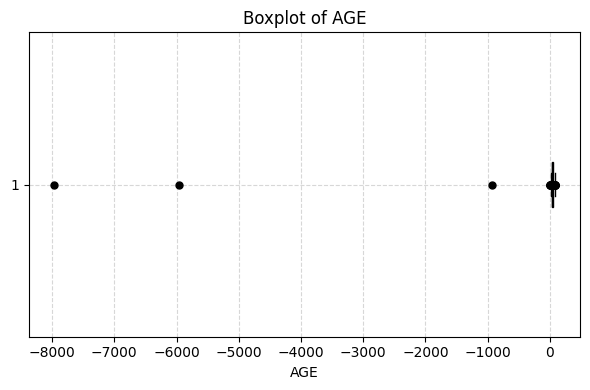

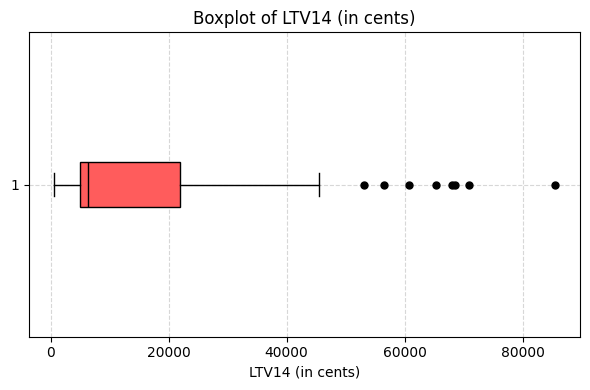

Boxlot for: fact_visits_df:


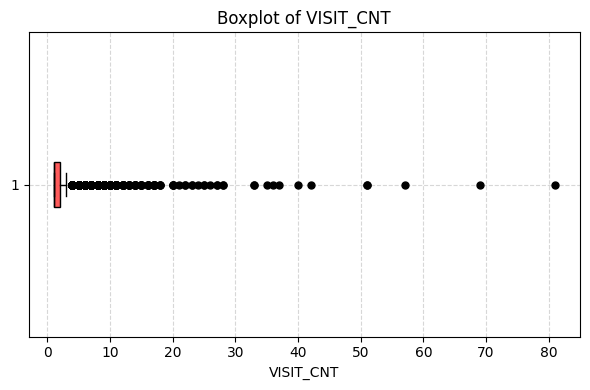

Boxlot for: fact_purchases_df:


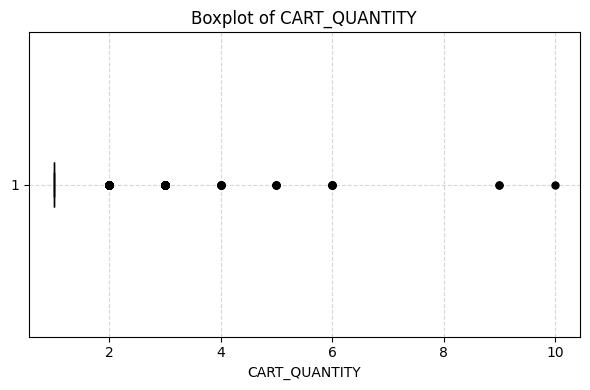

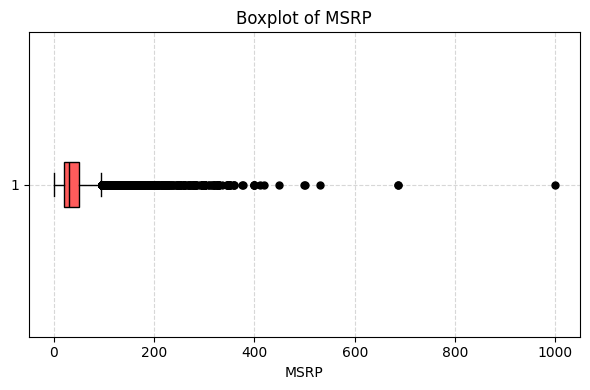

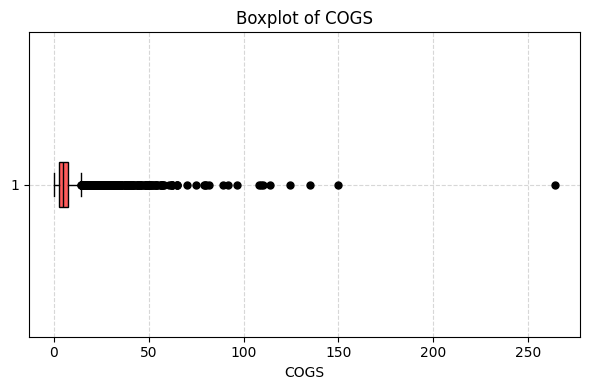

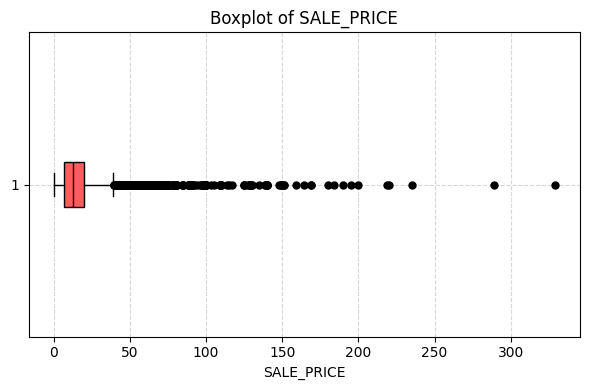

In [16]:
# Boxplots
for name, df in dfs.items():
    if name != 'dim_campaign_df':
        print(f"Boxlot for: {name}:")
        numeric_boxplots(df)

For the analysis above, we can see that:
* `fact_acquisitions_df (AGE)` - several outliers that are WRONG, so they should be dropped
* `fact_acquisitions_df (LTV14)` - several outliers but we can't assume it's wrong or not, but since they are not much, we'll keep them
* `fact_visits_df (VISIT_CNT)` - We can't assume it's wrong, we'll keep it
* `fact_purchases_df (CART_QUANTITY)` - A few outliers but we can't assume it's wrong or not, but since they are not much, we'll keep them
* `fact_purchases_df (MSRP)` - A few outliers but we can't assume it's wrong or not, but since they are not much, we'll keep them
* `fact_purchases_df (COGS)` - A few outliers but we can't assume it's wrong or not, but since they are not much, we'll keep them
* `fact_purchases_df (SALE_PRICE)` - A few outliers but we can't assume it's wrong or not


##### 3.3.1.2 Distributions

In [17]:
def numeric_histograms(df, color="#FF5C5C", bins=30):
    numeric_cols = df.select_dtypes(include=['number']).columns

    for col in numeric_cols:
        plt.figure(figsize=(6, 4))
        plt.hist(df[col].dropna(), bins=bins, color=color, edgecolor='black')
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

Boxlot for: fact_acquisitions_df:


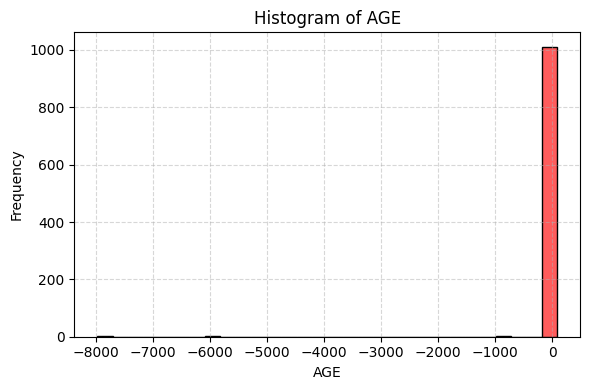

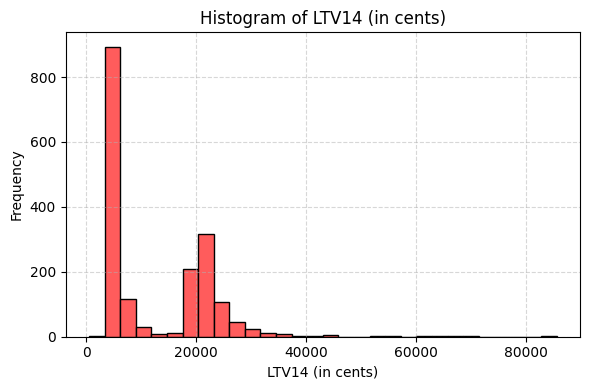

Boxlot for: fact_visits_df:


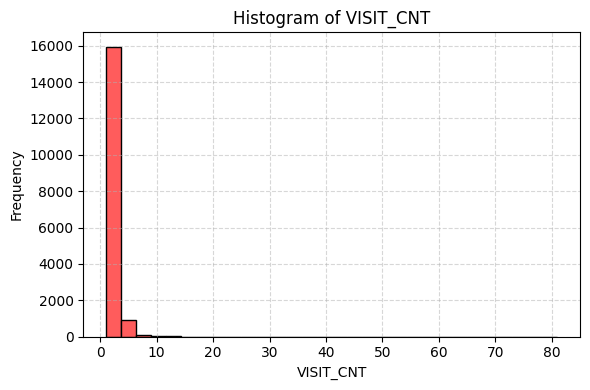

Boxlot for: fact_purchases_df:


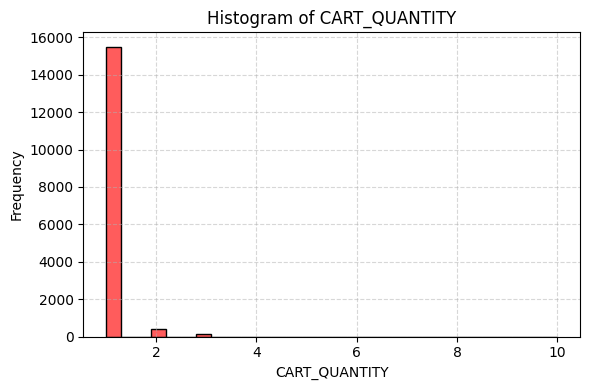

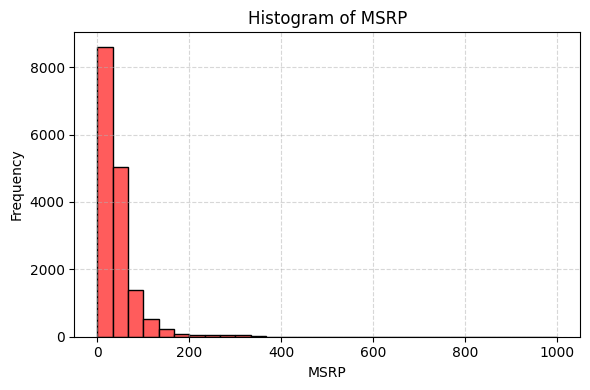

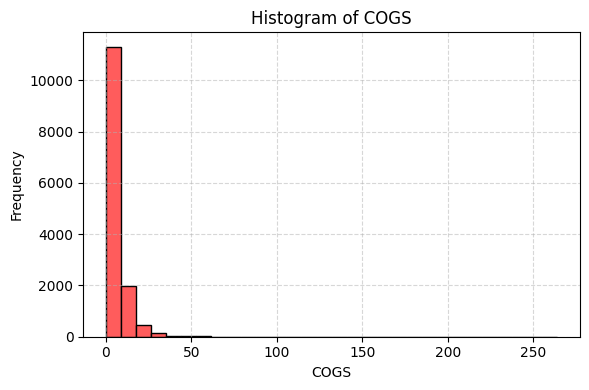

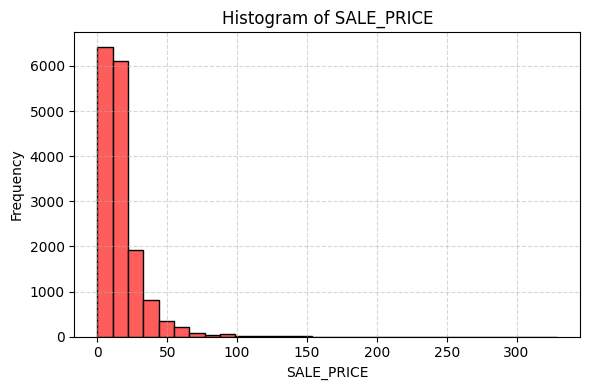

In [18]:
# 
for name, df in dfs.items():
    if name != 'dim_campaign_df':
        print(f"Boxlot for: {name}:")
        numeric_histograms(df)

#### 3.3.2 Qualitative Variables

Check if the users from the tables are unique (PK) or not.

In [ ]:
# Function for uniqueness
def check_unique(df, name):
    if df['userID'].is_unique:
        print(f"{name}: The userID IS unique in this table.")
    else:
        print(f"{name}: The userID IS NOT unique in this table.")

In [ ]:
# Check uniqueness
check_unique(fact_purchases_df, "fact_purchases_df")
check_unique(fact_visits_df, "fact_visits_df")
check_unique(fact_acquisitions_df, "fact_acquisitions_df")

fact_purchases_df: The userID IS NOT unique in this table.
fact_visits_df: The userID IS NOT unique in this table.
fact_acquisitions_df: The userID IS unique in this table.


Check the unique values for each categorical column.

In [19]:
# Unique values for qualitative variables
def unique_values(df):
    obj_cols = df.select_dtypes(include=['object', 'string']).columns
    for col in obj_cols:
        n_unique = df[col].nunique(dropna=False)
        print(f"{col}: {n_unique}")

In [20]:
# Display 
for name, df in dfs.items():
    print(f'Unique values in {name}: ')
    unique_values(df)
    print(f'\n')

Unique values in fact_acquisitions_df: 
userID: 1800
ORDER_SEASON: 18
PLAN_CODE: 2
CURRENT_SUBSCRIPTIONS_STATE: 3
USER_REGION: 8


Unique values in fact_visits_df: 
userID: 1327
SEASON: 12
CAMPAIGN_ID: 98
WINDOW_NUMBER: 2
CAMPAIGN_TITLE: 96
CAMPAIGN_TYPE: 6
CHANNEL: 8
NEW_OR_RETURNING_MEMBER: 3


Unique values in fact_purchases_df: 
userID: 985
CAMPAIGN_ID: 180
CAMPAIGN_TITLE: 176
SKU: 8093
CATEGORY: 17


Unique values in dim_campaign_df: 
SEASON: 13
CAMPAIGN_ID: 110
CAMPAIGN_TITLE: 108
CAMPAIGN_TYPE: 6




Now, check the quantity of values per attribute.

In [21]:
# Function to check categorical distributions
def categorical_distributions(df, categorical_columns, color="#FF5C5C"):
    for col in categorical_columns:
        counts = df[col].value_counts(dropna=False)  # inclui NaNs
        plt.figure(figsize=(8, 4))
        counts.plot(kind='bar', color=color, edgecolor='black')
        plt.title(f"Value Counts of '{col}'")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

Dim Campaing:

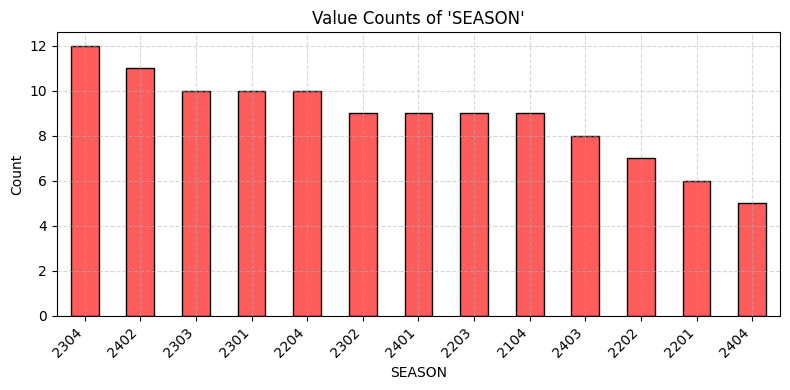

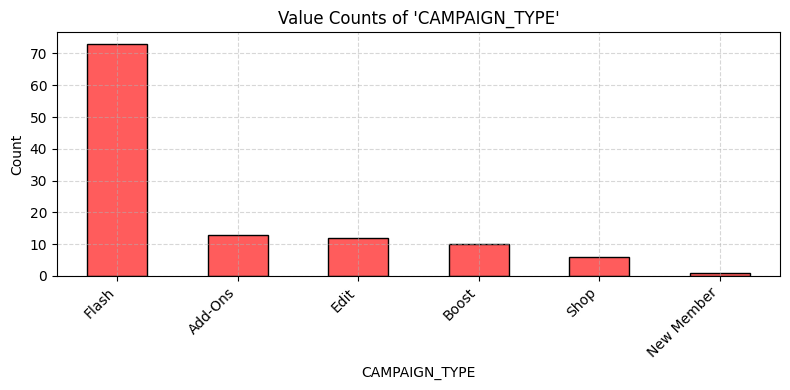

In [22]:
dim_campaign_cat_columns = ['SEASON', 'CAMPAIGN_TYPE']
categorical_distributions(dim_campaign_df, dim_campaign_cat_columns)

Purchases:

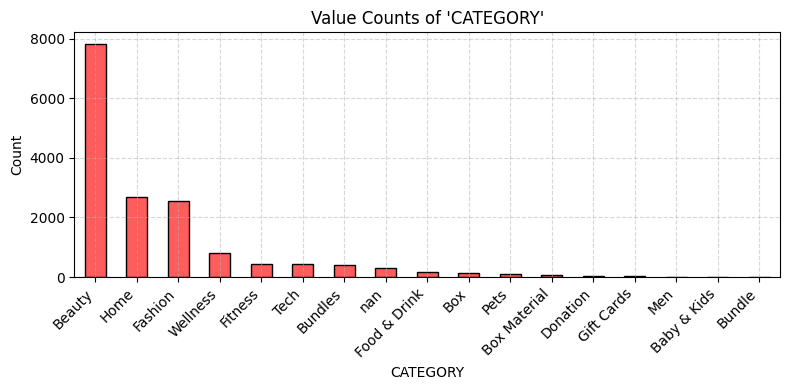

In [23]:
fact_purchases_cat_columns = ['CATEGORY']
categorical_distributions(fact_purchases_df, fact_purchases_cat_columns)

Visits:

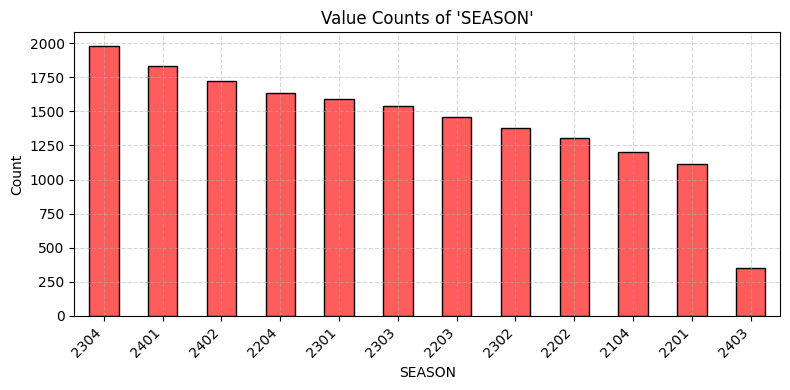

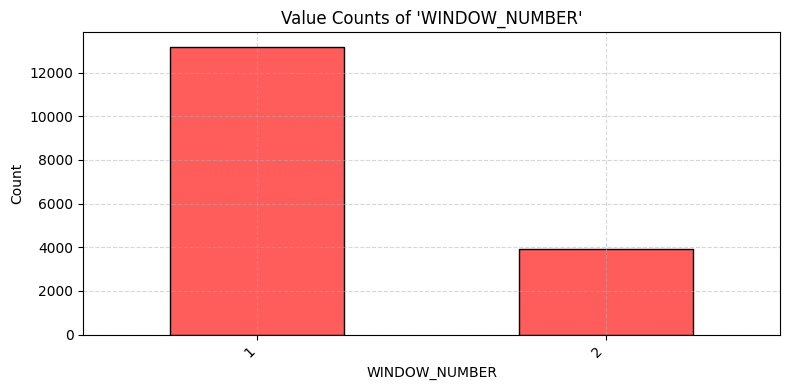

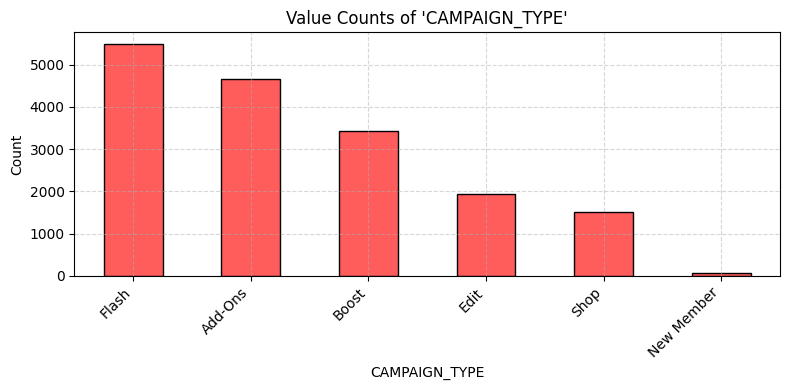

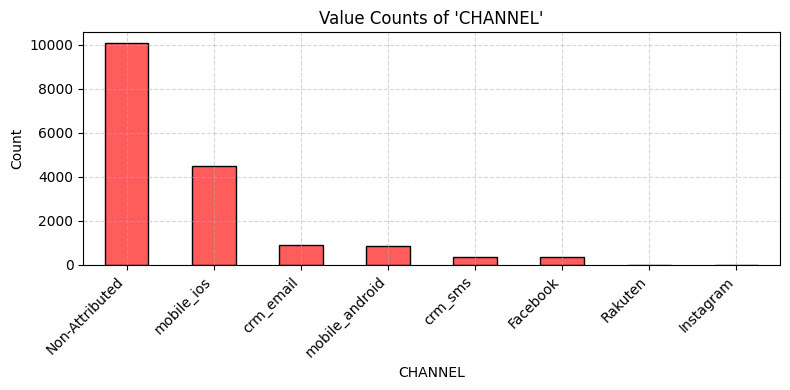

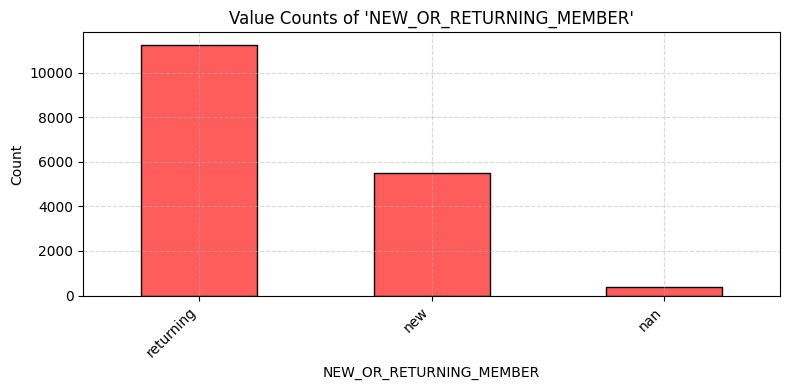

In [24]:
fact_visits_cat_columns = ['SEASON', 'WINDOW_NUMBER', 'CAMPAIGN_TYPE', 'CHANNEL', 'NEW_OR_RETURNING_MEMBER']
categorical_distributions(fact_visits_df, fact_visits_cat_columns)

Acquisition:

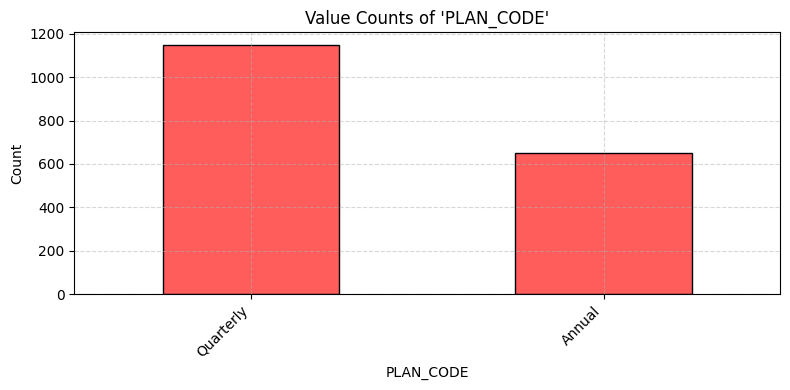

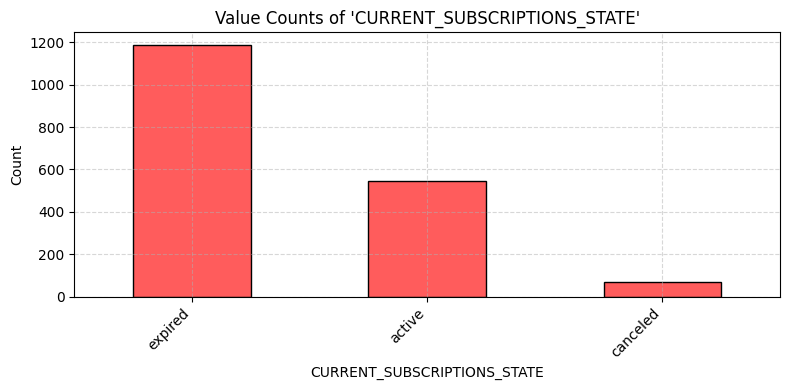

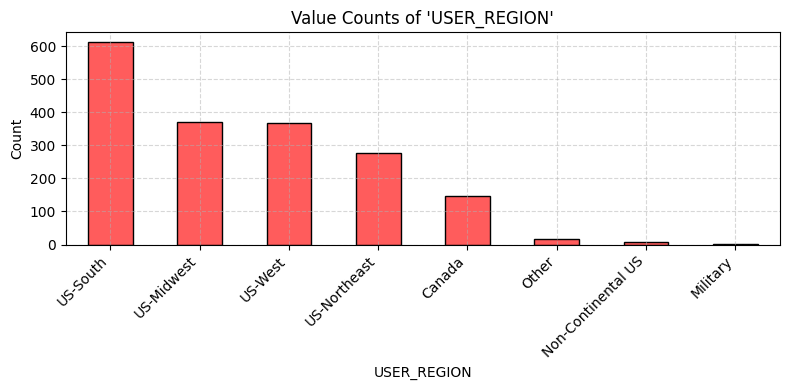

In [25]:
fact_acquisitions_cat_columns = ['PLAN_CODE', 'CURRENT_SUBSCRIPTIONS_STATE', 'USER_REGION']
categorical_distributions(fact_acquisitions_df, fact_acquisitions_cat_columns)

#### 3.3.1 Data GAP (INCONSISTANCES)

##### 3.3.1.1 Campaigns in Purchases and Visits

In [ ]:
# Campaigns from each table
purchases_campaigns = set(fact_purchases_df['CAMPAIGN_ID'].dropna().unique())
visits_campaigns = set(fact_visits_df['CAMPAIGN_ID'].dropna().unique())
dim_campaigns = set(dim_campaign_df['CAMPAIGN_ID'].dropna().unique())

# Check if all campaigns from purchases are in the dimension table
missing_in_dim_from_purchases = purchases_campaigns - dim_campaigns
print(f"Purchases → Missing in dim_campaign_df: {len(missing_in_dim_from_purchases)}")
print(missing_in_dim_from_purchases)

# Check if all campaigns from visits are in the dimension table
missing_in_dim_from_visits = visits_campaigns - dim_campaigns
print(f"Visits → Missing in dim_campaign_df: {len(missing_in_dim_from_visits)}")
print(missing_in_dim_from_visits)

Purchases → Missing in dim_campaign_df: 84
{'191', '141', '64', '127', '118', '192', '114', '88', '210', '163', '186', '137', '95', '89', '67', '158', '135', '122', '65', '90', '104', '128', '278', '120', '111', '233', '76', '81', '157', '187', '94', '68', '130', '100', '133', '80', '143', '211', '108', '101', '193', '142', '121', '188', '256', '91', '83', '132', '93', '138', '245', '268', '182', '113', '87', '97', '195', '119', '78', '74', '124', '98', '103', '92', '123', '134', '77', '129', '185', '126', '117', '136', '194', '82', '222', '171', '190', '110', '140', '139', '96', '183', '116', '125'}
Visits → Missing in dim_campaign_df: 0
set()


##### 3.3.1.2 Dim Campaigns vs Visits and Purchases

In [91]:
# Campaigns from each table
purchases_campaigns = set(fact_purchases_df['CAMPAIGN_ID'].dropna().unique())
visits_campaigns = set(fact_visits_df['CAMPAIGN_ID'].dropna().unique())

# Campaigns present in both
campaigns_in_both = purchases_campaigns & visits_campaigns
print(f"Campaigns present in both purchases and visits: {len(campaigns_in_both)}")
print(campaigns_in_both)

# Campaigns only in purchases
campaigns_only_in_purchases = purchases_campaigns - visits_campaigns
print(f"Campaigns only in purchases: {len(campaigns_only_in_purchases)}")
print(campaigns_only_in_purchases)

# Campaigns only in visits
campaigns_only_in_visits = visits_campaigns - purchases_campaigns
print(f"Campaigns only in visits: {len(campaigns_only_in_visits)}")
print(campaigns_only_in_visits)


Campaigns present in both purchases and visits: 96
{'197', '164', '266', '209', '218', '181', '214', '148', '165', '145', '144', '235', '212', '232', '246', '241', '229', '149', '237', '155', '177', '231', '168', '202', '153', '178', '230', '169', '107', '204', '267', '258', '179', '255', '226', '173', '152', '262', '199', '208', '198', '264', '239', '254', '251', '228', '162', '203', '221', '238', '184', '249', '224', '260', '206', '253', '263', '147', '216', '170', '240', '150', '217', '236', '196', '252', '215', '219', '201', '200', '160', '205', '269', '265', '180', '250', '243', '151', '259', '248', '242', '176', '223', '154', '227', '244', '161', '261', '207', '159', '220', '225', '166', '167', '172', '174'}
Campaigns only in purchases: 84
{'191', '141', '64', '127', '118', '192', '114', '88', '210', '163', '186', '137', '95', '89', '67', '158', '135', '122', '65', '90', '104', '128', '278', '120', '111', '233', '76', '81', '157', '187', '94', '68', '130', '100', '133', '80', '14

##### 3.3.1.3 Users in Purchases and Visits

In [ ]:
# UserIDs from each table
purchases_users = set(fact_purchases_df['userID'].dropna().unique())
visits_users = set(fact_visits_df['userID'].dropna().unique())

# Users in purchases but not in visits
missing_in_visits = purchases_users - visits_users
print(f"userIDs in purchases but not in visits: {len(missing_in_visits)}")
print(list(missing_in_visits)[:10])  # optional sample

# Users in visits but not in purchases
missing_in_purchases = visits_users - purchases_users
print(f"userIDs in visits but not in purchases: {len(missing_in_purchases)}")
print(list(missing_in_purchases)[:10])  # optional sample

userIDs in purchases but not in visits: 112
['04a3269597c83b780b2c5ca59880a7fe', 'f2aeac80b3a0bcf304c51aeb7eea17bc', '998a1f12d0d5839a29b03ecefe8b2835', '5062ab6c9283ae2d386fc112b62cabbe', '307e26e97ef66bfef8c7d5ec0e10b224', '22573eb16bdd2b395a7371c2c724e8e4', '76678ba56731c029e067861817c752ae', '8792c4e54a0f84f91f22ca3371ffa69d', '36b5b9663f181035160f29e2aa00841f', '4262adf25977ba2a7de669df45e18ac2']
userIDs in visits but not in purchases: 454
['03d3d1c916ee96d0b82b9309c595ff51', '0fc614a6ffb63d932c417591c5d4da0c', 'c172f6a5b633d1ba874de98cd11b885c', 'b5ef0d18d6d513f7111e446d3dc5cf6a', '3c3fc9bfbb3345285cceffe819a078ad', 'f01eccd85ec7f79ff9087d8ad3926f9f', '86bc3dad1ce48bc7a96fd6fa2672c0ec', '7d61c3e79616bb49f85b9651b1d42a50', '0f103e5231ce1caeafa4c11dcdd542c1', '2627f320698d6bf3257b05334cbac780']


#### 3.3.1.4 - Nulls, NaNs and Missings

In [93]:
# Function to check nulls
def nulls_evaluation(df, name):
    print(f"Dataframe: {name}")
    total_rows = len(df)
    pct_missing = (df.isnull().sum() / total_rows * 100).round(1)

    has_missing = False
    for col, pct in pct_missing.items():
        if pct > 0:
            print(f"{col}: {pct}%")
            has_missing = True

    if not has_missing:
        print("No missing values.")
    print("-" * 30)

In [92]:
# Check nulls for all dataframes
for name, df in dfs.items():
    nulls_evaluation(df, name)

Dataframe: fact_acquisitions_df
AGE: 43.7%
------------------------------
Dataframe: fact_visits_df
NEW_OR_RETURNING_MEMBER: 2.1%
------------------------------
Dataframe: fact_purchases_df
COGS: 12.7%
CATEGORY: 1.8%
------------------------------
Dataframe: dim_campaign_df
No missing values.
------------------------------


The dataset `fact_acquisitions_df` has a huge quantity of missing ages, meaning that we probably will not use this column.

#### 3.3.1.5 - Join Visits and Purchases

Let's join both tables to understand the situation due to lack of users and campaigns present in both tables. We'll perform a left join from purchaes to visits since purchases is the most important.

In [267]:
# Selecting columns
fact_visits_filtered = (
    fact_visits_df
    .sort_values('WINDOW_END_TS_PST')
    .drop_duplicates(subset=['userID', 'CAMPAIGN_ID'], keep='last')
    [['userID', 'CAMPAIGN_ID', 'WINDOW_START_TS_PST', 'WINDOW_END_TS_PST']]
)

# Left Join
result_df = fact_purchases_df.merge(
    fact_visits_filtered,
    on=['userID', 'CAMPAIGN_ID'],
    how='left'
)

# Null percentage for each column
null_percentages = result_df.isna().mean() * 100

# Display formatted result
print(null_percentages.round(2))

userID                  0.00
CAMPAIGN_ID             0.00
CAMPAIGN_TITLE          0.00
SKU                     0.00
CART_QUANTITY           0.00
MSRP                    0.00
COGS                   12.71
SALE_PRICE              0.00
CATEGORY                1.81
WINDOW_START_TS_PST    29.29
WINDOW_END_TS_PST      29.29
dtype: float64


## 3 Data Preprocessing

### 3.1 Null Treatment

Since we have a lack of campaigns in purchases in order to left join with visits, we'll neeed to treat them (the dates). We can't search for same values of `WINDOW_START_TS_PST` and `WINDOW_END_TS_PST` according to campaigns because 84 campaigns are only available in purchases, so we don't have more information about them.

Let's use the following logic for Null columns from start and end date:
1. Check the campaign description, if there's "Spring, Summer, Fall or Winter" + year, we'll stablish as the first day of that season as the campaign end (considering NORTH AMERICA SEASON DATES)
2. If there's no information about it, we'll get the date from `fact_acquisitions_df`

In [282]:
# Constraints
SEASON_START = {
    'Spring': (3, 1),
    'Summer': (6, 1),
    'Fall':   (9, 1),
    'Winter': (12, 1),
}

SEASON_NAME_ORDER = {'Spring': 1, 'Summer': 2, 'Fall': 3, 'Winter': 4}
MONTH_TO_SEASON = {
    1: 'Winter', 2: 'Winter', 3: 'Spring',
    4: 'Spring', 5: 'Spring', 6: 'Summer',
    7: 'Summer', 8: 'Summer', 9: 'Fall',
    10: 'Fall', 11: 'Fall', 12: 'Winter'
}

In [314]:
# General Functions
def filter_latest_visits(fact_visits_df):
    """
    Sorts visits by window end timestamp and returns only the latest visit per user and campaign.
    """
    fact_visits_df_sorted = fact_visits_df.sort_values('WINDOW_END_TS_PST')
    fact_visits_filtered = fact_visits_df_sorted.drop_duplicates(
        subset=['userID', 'CAMPAIGN_ID'],
        keep='last'
    )
    return fact_visits_filtered[['userID', 'CAMPAIGN_ID', 'WINDOW_START_TS_PST', 'WINDOW_END_TS_PST']]

def extract_season_start(title):
    """
    Extracts the start date of a season from a campaign title using either 'Season YYYY' or 'YYYY Season'.
    Returns a Timestamp or NaT if not found.
    """
    title = title.lower()
    seasons = ['spring', 'summer', 'fall', 'winter']
    for season in seasons:
        match1 = re.search(fr'{season}.*?(\d{{4}})', title)
        match2 = re.search(fr'(\d{{4}}).*?{season}', title)
        if match1:
            year = int(match1.group(1))
            month, day = SEASON_START[season.title()]
            return Timestamp(year, month, day)
        elif match2:
            year = int(match2.group(1))
            month, day = SEASON_START[season.title()]
            return Timestamp(year, month, day)
    return pd.NaT

def apply_season_start_estimate(df):
    """
    Applies the extract_season_start function to the CAMPAIGN_TITLE column and stores result in 'season_start_estimate'.
    """
    df['season_start_estimate'] = df['CAMPAIGN_TITLE'].apply(extract_season_start)
    return df

def merge_acquisition_dates(df, acquisitions_df):
    """
    Joins the acquisition date from fact_acquisitions_df into the result_df using userID.
    Renames the column to 'acquisition_date'.
    """
    df = df.merge(
        acquisitions_df[['userID', 'ACQUISITION_DATE']],
        on='userID',
        how='left'
    )
    df.rename(columns={'ACQUISITION_DATE': 'acquisition_date'}, inplace=True)
    return df

def remove_timezones(df, column_list):
    """
    Converts datetime columns to timezone-naive format and ensures they are parsed correctly.
    """
    for col in column_list:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        if pd.api.types.is_datetime64tz_dtype(df[col]):
            df[col] = df[col].dt.tz_localize(None)
    return df

def create_reference_date(df):
    """
    Creates REFERENCE_DATE using the fallback logic:
    WINDOW_END_TS_PST → season_start_estimate → acquisition_date.
    """
    df['REFERENCE_DATE'] = (
        df['WINDOW_END_TS_PST']
        .combine_first(df['season_start_estimate'])
        .combine_first(df['acquisition_date'])
    )
    df['REFERENCE_DATE'] = pd.to_datetime(df['REFERENCE_DATE'], errors='coerce').dt.date
    return df

def extract_reference_parts(df):
    """
    Extracts REFERENCE_YEAR, REFERENCE_MONTH, and REFERENCE_DAY from the REFERENCE_DATE.
    """
    reference_datetime = pd.to_datetime(df['REFERENCE_DATE'], errors='coerce')
    df['REFERENCE_YEAR'] = reference_datetime.dt.year
    df['REFERENCE_MONTH'] = reference_datetime.dt.month
    df['REFERENCE_DAY'] = reference_datetime.dt.day
    return df

def extract_season_name_from_title(title):
    """
    Extracts season name (Spring, Summer, Fall, Winter) from the campaign title if present.
    """
    title = title.lower()
    seasons = ['spring', 'summer', 'fall', 'winter']
    for season in seasons:
        if season in title:
            return season.title()
    return None

def apply_season_name_and_number(df):
    """
    Derives SEASON_NAME and SEASON_NUMBER based on CAMPAIGN_TITLE or REFERENCE_MONTH.
    """
    df['SEASON_NAME'] = df['CAMPAIGN_TITLE'].apply(extract_season_name_from_title)
    df['SEASON_NAME'] = df['SEASON_NAME'].fillna(df['REFERENCE_MONTH'].map(MONTH_TO_SEASON))
    df['SEASON_NUMBER'] = df['SEASON_NAME'].map(SEASON_NAME_ORDER)
    return df

def drop_intermediate_columns(df):
    """
    Drops intermediate columns used in date logic: start, end, and estimated season/acquisition dates.
    """
    return df.drop(columns=[
        'WINDOW_START_TS_PST',
        'WINDOW_END_TS_PST',
        'season_start_estimate',
        'acquisition_date'
    ])

In [315]:
# Orchestractor Functions
def build_result_df(fact_purchases_df, fact_visits_df, fact_acquisitions_df):
    """
    Full pipeline to enrich fact_purchases_df with:
    - latest visit info
    - estimated and fallback dates
    - season name and number
    - year, month, and day from final REFERENCE_DATE
    - Transforming reference date into date time
    - Season index = (REFERENCE_YEAR - 1) * 4 + SEASON_NUMBER
    """
    visits_filtered = filter_latest_visits(fact_visits_df)
    df = fact_purchases_df.merge(visits_filtered, on=['userID', 'CAMPAIGN_ID'], how='left')
    df = apply_season_start_estimate(df)
    df = merge_acquisition_dates(df, fact_acquisitions_df)
    df = remove_timezones(df, ['WINDOW_END_TS_PST', 'season_start_estimate', 'acquisition_date'])
    df = create_reference_date(df)
    df = drop_intermediate_columns(df)
    df = extract_reference_parts(df)
    df = apply_season_name_and_number(df)
    df['REFERENCE_DATE'] = pd.to_datetime(df['REFERENCE_DATE'], errors='coerce')
    df['SEASON_INDEX'] = ((df['REFERENCE_YEAR'] - 1) * 4 + df['SEASON_NUMBER'])
    return df

"No calendário gregoriano, o primeiro ano é o ano 1 d.C., e não o ano 0. O ano 1 d.C. sucede diretamente ao ano 1 a.C., sem que exista um ano intermediário (o ano 0)."

In [316]:
# Final df
purchases_with_dates_df = build_result_df(fact_purchases_df, fact_visits_df, fact_acquisitions_df)

# Display
purchases_with_dates_df.head(5)

,userID,CAMPAIGN_ID,CAMPAIGN_TITLE,SKU,CART_QUANTITY,MSRP,COGS,SALE_PRICE,CATEGORY,REFERENCE_DATE,REFERENCE_YEAR,REFERENCE_MONTH,REFERENCE_DAY,SEASON_NAME,SEASON_NUMBER,SEASON_INDEX
0,c805311614ffdce7c072fe7f8fd2d819,161,Summer Add Ons 2022,IDI-HO-775-DS,1,24.99,9.00,19.0,Beauty,2022-05-17,2022,5,17,Summer,2,8086
1,b457a1f041c3efd6f61407767c3610a8,119,Summer Add Ons 2021,2102-GWP-001,1,0.00,2.43,0.0,NaN,2021-06-01,2021,6,1,Summer,2,8082
2,5062ab6c9283ae2d386fc112b62cabbe,97,Winter Add Ons 2020,ZOE-BE-026,1,29.99,3.30,9.0,Beauty,2020-12-01,2020,12,1,Winter,4,8080
3,c89845baa12a0a8dc8068c37bf155fbe,76,Summer 2020 Add-Ons,THI-HO-001,1,34.00,1.70,9.0,Wellness,2020-06-01,2020,6,1,Summer,2,8078
4,6c98a29e875bfb651918f2fd82956426,76,Summer 2020 Add-Ons,LAI-BE-007,1,46.00,6.00,17.0,Beauty,2020-06-01,2020,6,1,Summer,2,8078


Impact after using this business logic.

In [331]:
# Step 1 — Join purchases + visits
visits_filtered = filter_latest_visits(fact_visits_df)

df = fact_purchases_df.merge(
    visits_filtered,
    on=['userID', 'CAMPAIGN_ID'],
    how='left'
)

total_rows = df.shape[0]
missing_after_visits = df['WINDOW_END_TS_PST'].isna().sum()
pct_missing_after_visits = (missing_after_visits / total_rows) * 100

print(f"After join with visits: {missing_after_visits} rows missing ({pct_missing_after_visits:.2f}%)")

# Step 2 — Apply regex (season_start_estimate)
df = apply_season_start_estimate(df)
still_missing_after_regex = (
    df['WINDOW_END_TS_PST'].isna() &
    df['season_start_estimate'].isna()
).sum()
pct_missing_after_regex = (still_missing_after_regex / total_rows) * 100

print(f"After regex fallback: {still_missing_after_regex} rows missing ({pct_missing_after_regex:.2f}%)")

# Step 3 — Merge acquisition date
df = merge_acquisition_dates(df, fact_acquisitions_df)
df = remove_timezones(df, ['WINDOW_END_TS_PST', 'season_start_estimate', 'acquisition_date'])

# Step 4 — Create REFERENCE_DATE
df = create_reference_date(df)

missing_final = df['REFERENCE_DATE'].isna().sum()
pct_missing_final = (missing_final / total_rows) * 100

print(f"After acquisition fallback: {missing_final} rows missing ({pct_missing_final:.2f}%)")


After join with visits: 4705 rows missing (29.29%)
After regex fallback: 1867 rows missing (11.62%)
After acquisition fallback: 0 rows missing (0.00%)


### 4.1 Valuable Users - RFM



Calculate the R - RECENCY.

In [332]:
# Collect the MAX CAMPAIGN TIMESTAMP and set as the 'current' date
current_season_index = purchases_with_dates_df['SEASON_INDEX'].max()

# Step 2 — Get the user's most recent season
user_last_season = (
    purchases_with_dates_df
    .groupby('userID', as_index=False)['SEASON_INDEX']
    .max()
    .rename(columns={'SEASON_INDEX': 'USER_LAST_SEASON_INDEX'})
)

# Step 3 — Calculate RECENCY in number of seasons
user_last_season['RECENCY_SEASON'] = current_season_index - user_last_season['USER_LAST_SEASON_INDEX']

# Display
user_last_season.head()

,userID,USER_LAST_SEASON_INDEX,RECENCY_SEASON
0,00e1652e0a249f65810507ce2a6ded73,8095,1
1,01186aab51de65876d40e758b398ac3a,8092,4
2,011a108b9bbe8e6a494e23d2cf782f4a,8094,2
3,015c290d8fc1087c0e835f513f1b924e,8092,4
4,01653f6844293d8e9e6e6e736f78cdb3,8094,2


Calculate the F - FREQUENCY.

In [335]:
# Step 1 — Count number of distinct SEASON_INDEX per user (frequency por season)
user_frequency = (
    purchases_with_dates_df
    .groupby('userID', as_index=False)['SEASON_INDEX']
    .nunique()
    .rename(columns={'SEASON_INDEX': 'FREQUENCY_SEASON'})
)

# Joining with the recency
rf_df = user_last_season.merge(user_frequency, on='userID', how='left')

# Display
rf_df.head()

,userID,USER_LAST_SEASON_INDEX,RECENCY_SEASON,FREQUENCY_SEASON
0,00e1652e0a249f65810507ce2a6ded73,8095,1,3
1,01186aab51de65876d40e758b398ac3a,8092,4,2
2,011a108b9bbe8e6a494e23d2cf782f4a,8094,2,1
3,015c290d8fc1087c0e835f513f1b924e,8092,4,3
4,01653f6844293d8e9e6e6e736f78cdb3,8094,2,4


Calculate the M - MONETARY.

In [337]:
purchases_with_dates_df['LINE_TOTAL'] = (
    purchases_with_dates_df['SALE_PRICE'] * purchases_with_dates_df['CART_QUANTITY']
)

user_monetary = (
    purchases_with_dates_df
    .groupby('userID', as_index=False)['LINE_TOTAL']
    .sum()
    .rename(columns={'LINE_TOTAL': 'MONETARY'})
)

rfm_df = rf_df.merge(user_monetary, on='userID', how='left')

rfm_df.head(5)

,userID,USER_LAST_SEASON_INDEX,RECENCY_SEASON,FREQUENCY_SEASON,MONETARY
0,00e1652e0a249f65810507ce2a6ded73,8095,1,3,145.98
1,01186aab51de65876d40e758b398ac3a,8092,4,2,35.00
2,011a108b9bbe8e6a494e23d2cf782f4a,8094,2,1,11.00
3,015c290d8fc1087c0e835f513f1b924e,8092,4,3,206.96
4,01653f6844293d8e9e6e6e736f78cdb3,8094,2,4,180.98


DEF

In [338]:
def calculate_rfm(purchases_df):
    """
    Calculates RFM (Recency in seasons, Frequency by unique seasons, Monetary by total sales)
    from a purchases DataFrame with the following columns:
    - userID
    - SEASON_NUMBER
    - REFERENCE_YEAR
    - SALE_PRICE
    - CART_QUANTITY
    """

    # Step 1 — Calculate SEASON_INDEX
    purchases_df = purchases_df.copy()
    purchases_df['SEASON_INDEX'] = (purchases_df['REFERENCE_YEAR'] - 1) * 4 + purchases_df['SEASON_NUMBER']

    # Step 2 — Calculate current season index (most recent season in the dataset)
    current_season_index = purchases_df['SEASON_INDEX'].max()

    # Step 3 — RECENCY: most recent season per user
    user_recency = (
        purchases_df
        .groupby('userID', as_index=False)['SEASON_INDEX']
        .max()
        .rename(columns={'SEASON_INDEX': 'USER_LAST_SEASON_INDEX'})
    )
    user_recency['RECENCY_SEASON'] = current_season_index - user_recency['USER_LAST_SEASON_INDEX']

    # Step 4 — FREQUENCY: number of unique seasons with purchases
    user_frequency = (
        purchases_df
        .groupby('userID', as_index=False)['SEASON_INDEX']
        .nunique()
        .rename(columns={'SEASON_INDEX': 'FREQUENCY'})
    )

    # Step 5 — MONETARY: total amount spent (price * quantity)
    purchases_df['LINE_TOTAL'] = purchases_df['SALE_PRICE'] * purchases_df['CART_QUANTITY']
    user_monetary = (
        purchases_df
        .groupby('userID', as_index=False)['LINE_TOTAL']
        .sum()
        .rename(columns={'LINE_TOTAL': 'MONETARY'})
    )

    # Step 6 — Join all RFM components
    rfm_df = user_recency.merge(user_frequency, on='userID', how='left')
    rfm_df = rfm_df.merge(user_monetary, on='userID', how='left')

    return rfm_df


In [339]:
rfm_df = calculate_rfm(purchases_with_dates_df)

rfm_df.head()

,userID,USER_LAST_SEASON_INDEX,RECENCY_SEASON,FREQUENCY,MONETARY
0,00e1652e0a249f65810507ce2a6ded73,8095,1,3,145.98
1,01186aab51de65876d40e758b398ac3a,8092,4,2,35.00
2,011a108b9bbe8e6a494e23d2cf782f4a,8094,2,1,11.00
3,015c290d8fc1087c0e835f513f1b924e,8092,4,3,206.96
4,01653f6844293d8e9e6e6e736f78cdb3,8094,2,4,180.98
